# Morty's Time Paradox

Solution author: Cowile

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Step 1: Load The Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trn = pd.read_csv("/kaggle/input/mortys-time-paradox-aicc-round-3/train.csv")
tst = pd.read_csv("/kaggle/input/mortys-time-paradox-aicc-round-3/test.csv")

X = trn.iloc[:, 1:9].values
cand = trn.iloc[:, 9:14].values
X_test = tst.iloc[:, 1:9].values

X_all = np.vstack([X, X_test]) # Combine features from the training and test sets

## Step 2: Determine Cyclic Periods

The problem states features are cyclic. We need to determine the period T for each feature by examining their ranges. The period should be approximately `ceil(max)` for each feature.

In [3]:
mins = X_all.min(axis=0)
maxs = X_all.max(axis=0)
T = np.rint(maxs).astype(int)
T = np.maximum(T, 1)

ranges = pd.DataFrame({"min": mins, "max": maxs, "T": T})
ranges.index = [f"x{i}" for i in range(X.shape[1])]
ranges

,min,max,T
x0,0.008416,10.999272,11
x1,0.010393,12.997244,13
x2,0.006611,16.997881,17
x3,0.013319,18.993695,19
x4,0.001282,10.994939,11
x5,0.009497,12.998363,13
x6,0.006156,16.987903,17
x7,0.011533,18.986551,19


## Step 3: Cyclic Encoding

For cyclic features, we apply the standard **sin/cos transformation**:

$$x \rightarrow \left( \sin\left(\frac{2\pi x}{T}\right), \cos\left(\frac{2\pi x}{T}\right) \right)$$

This transforms each feature into 2 components, preserving the cyclic nature of the data.

In [4]:
import math

def enc(X, T):
    n, d = X.shape
    Z = np.empty((n, 2 * d), dtype=np.float64)
    for j in range(d):
        a = 2 * math.pi * X[:, j] / float(T[j])
        Z[:, 2 * j] = np.sin(a)
        Z[:, 2 * j + 1] = np.cos(a)
    return Z

X_encoded = enc(X_all, T)

## Step 4. Visualizing the data with DOCTOR

In [5]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_encoded)

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=50, random_state=2026)
emb = tsne.fit_transform(X_scaled)

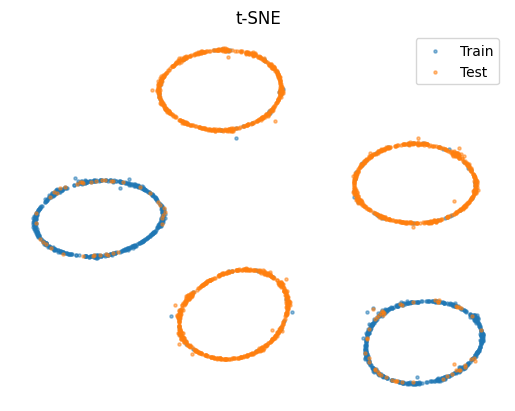

In [37]:
n_train = len(X)

plt.scatter(*emb[:n_train].T, s=5, alpha=0.5, label='Train')
plt.scatter(*emb[n_train:].T, s=5, alpha=0.5, label='Test')
plt.title('t-SNE')
plt.legend()
_ = plt.axis('off')

## Step 5. Clustering

In [24]:
from sklearn.cluster import SpectralClustering

cl = SpectralClustering(n_clusters=5, random_state=2026, assign_labels="cluster_qr", n_jobs=-1)
lab = cl.fit_predict(X_scaled)

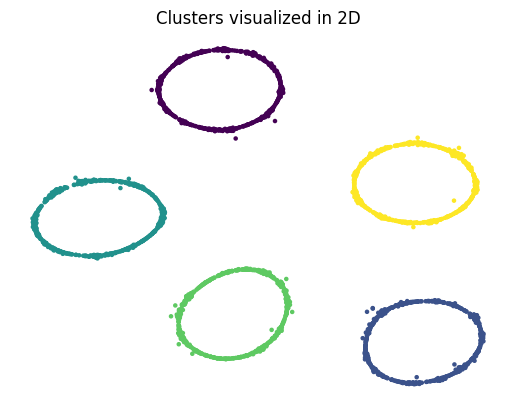

In [31]:
plt.scatter(*emb.T, c=lab, s=5)
plt.title("Clusters visualized in 2D")
plt.axis('off')
plt.show()

## Step 6. Majority Voting for Label Assignment

In [26]:
cluster_label = np.array([cand[:n_train][lab[:n_train] == k].sum(axis=0).argmax() for k in range(5)])
cluster_label

array([0, 3, 1, 2, 4])

In [27]:
pd.DataFrame(lab).value_counts()

0
1    502
3    502
0    499
4    499
2    498
Name: count, dtype: int64

In [29]:
test_labels = cluster_label[lab[n_train:]]

# Step 7: Generate Predictions

In [30]:
sub = pd.DataFrame({"row_id": tst.iloc[:, 0], "label": test_labels.astype(int)})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,label
0,0,4
1,1,2
2,2,2
3,3,4
4,4,0
